In [2]:
import torch, open_clip, PIL.Image as Image

# 1) pick a local model
model_name = "ViT-L-14"           # good balance of accuracy/speed
pretrained = "laion2b_s32b_b82k"              # or "laion2b_s32b_b82k", etc.
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained, device=device)
tokenizer = open_clip.get_tokenizer(model_name)



In [18]:
# 2) your candidate class names
class_names = [("swordsman", "blade weapons"), ("archer", "a bow and arrow"), ("mage", "magic"), ("brawler", "their bare fists"), ("gunslinger", "guns")]

templates = [
    "a drawing of a {}, most proficient at fighting with {}",
]

texts = [t.format(c, d) for c, d in class_names for t in templates]

with torch.no_grad():
    text_tokens = tokenizer(texts).to(device)
    text_emb = model.encode_text(text_tokens)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)
    # Average templates per class
    text_emb = text_emb.view(len(class_names), -1, text_emb.size(-1)).mean(dim=1)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)

# 3) classify one or more images
def classify(path):
    img = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        img_emb = model.encode_image(img)
        img_emb /= img_emb.norm(dim=-1, keepdim=True)
        # cosine similarity -> logits
        logits = 100.0 * img_emb @ text_emb.T
        probs = logits.softmax(dim=-1).squeeze(0)
    return [(class_names[i][0], float(probs[i])) for i in probs.topk(len(class_names)).indices][0][0]

print(classify("true/Elven archer by dimelife on DeviantArt.jpg"))


archer


In [19]:
import os
imagePaths = os.listdir("true")
from tqdm import tqdm
imageClasses = {}

In [ ]:


for idx, path in enumerate(tqdm(imagePaths)):
    if f"true/{path}" in imageClasses.keys():
        continue
    c = classify(f"true/{path}")
    imageClasses[f"true/{path}"] = c
print(imageClasses)

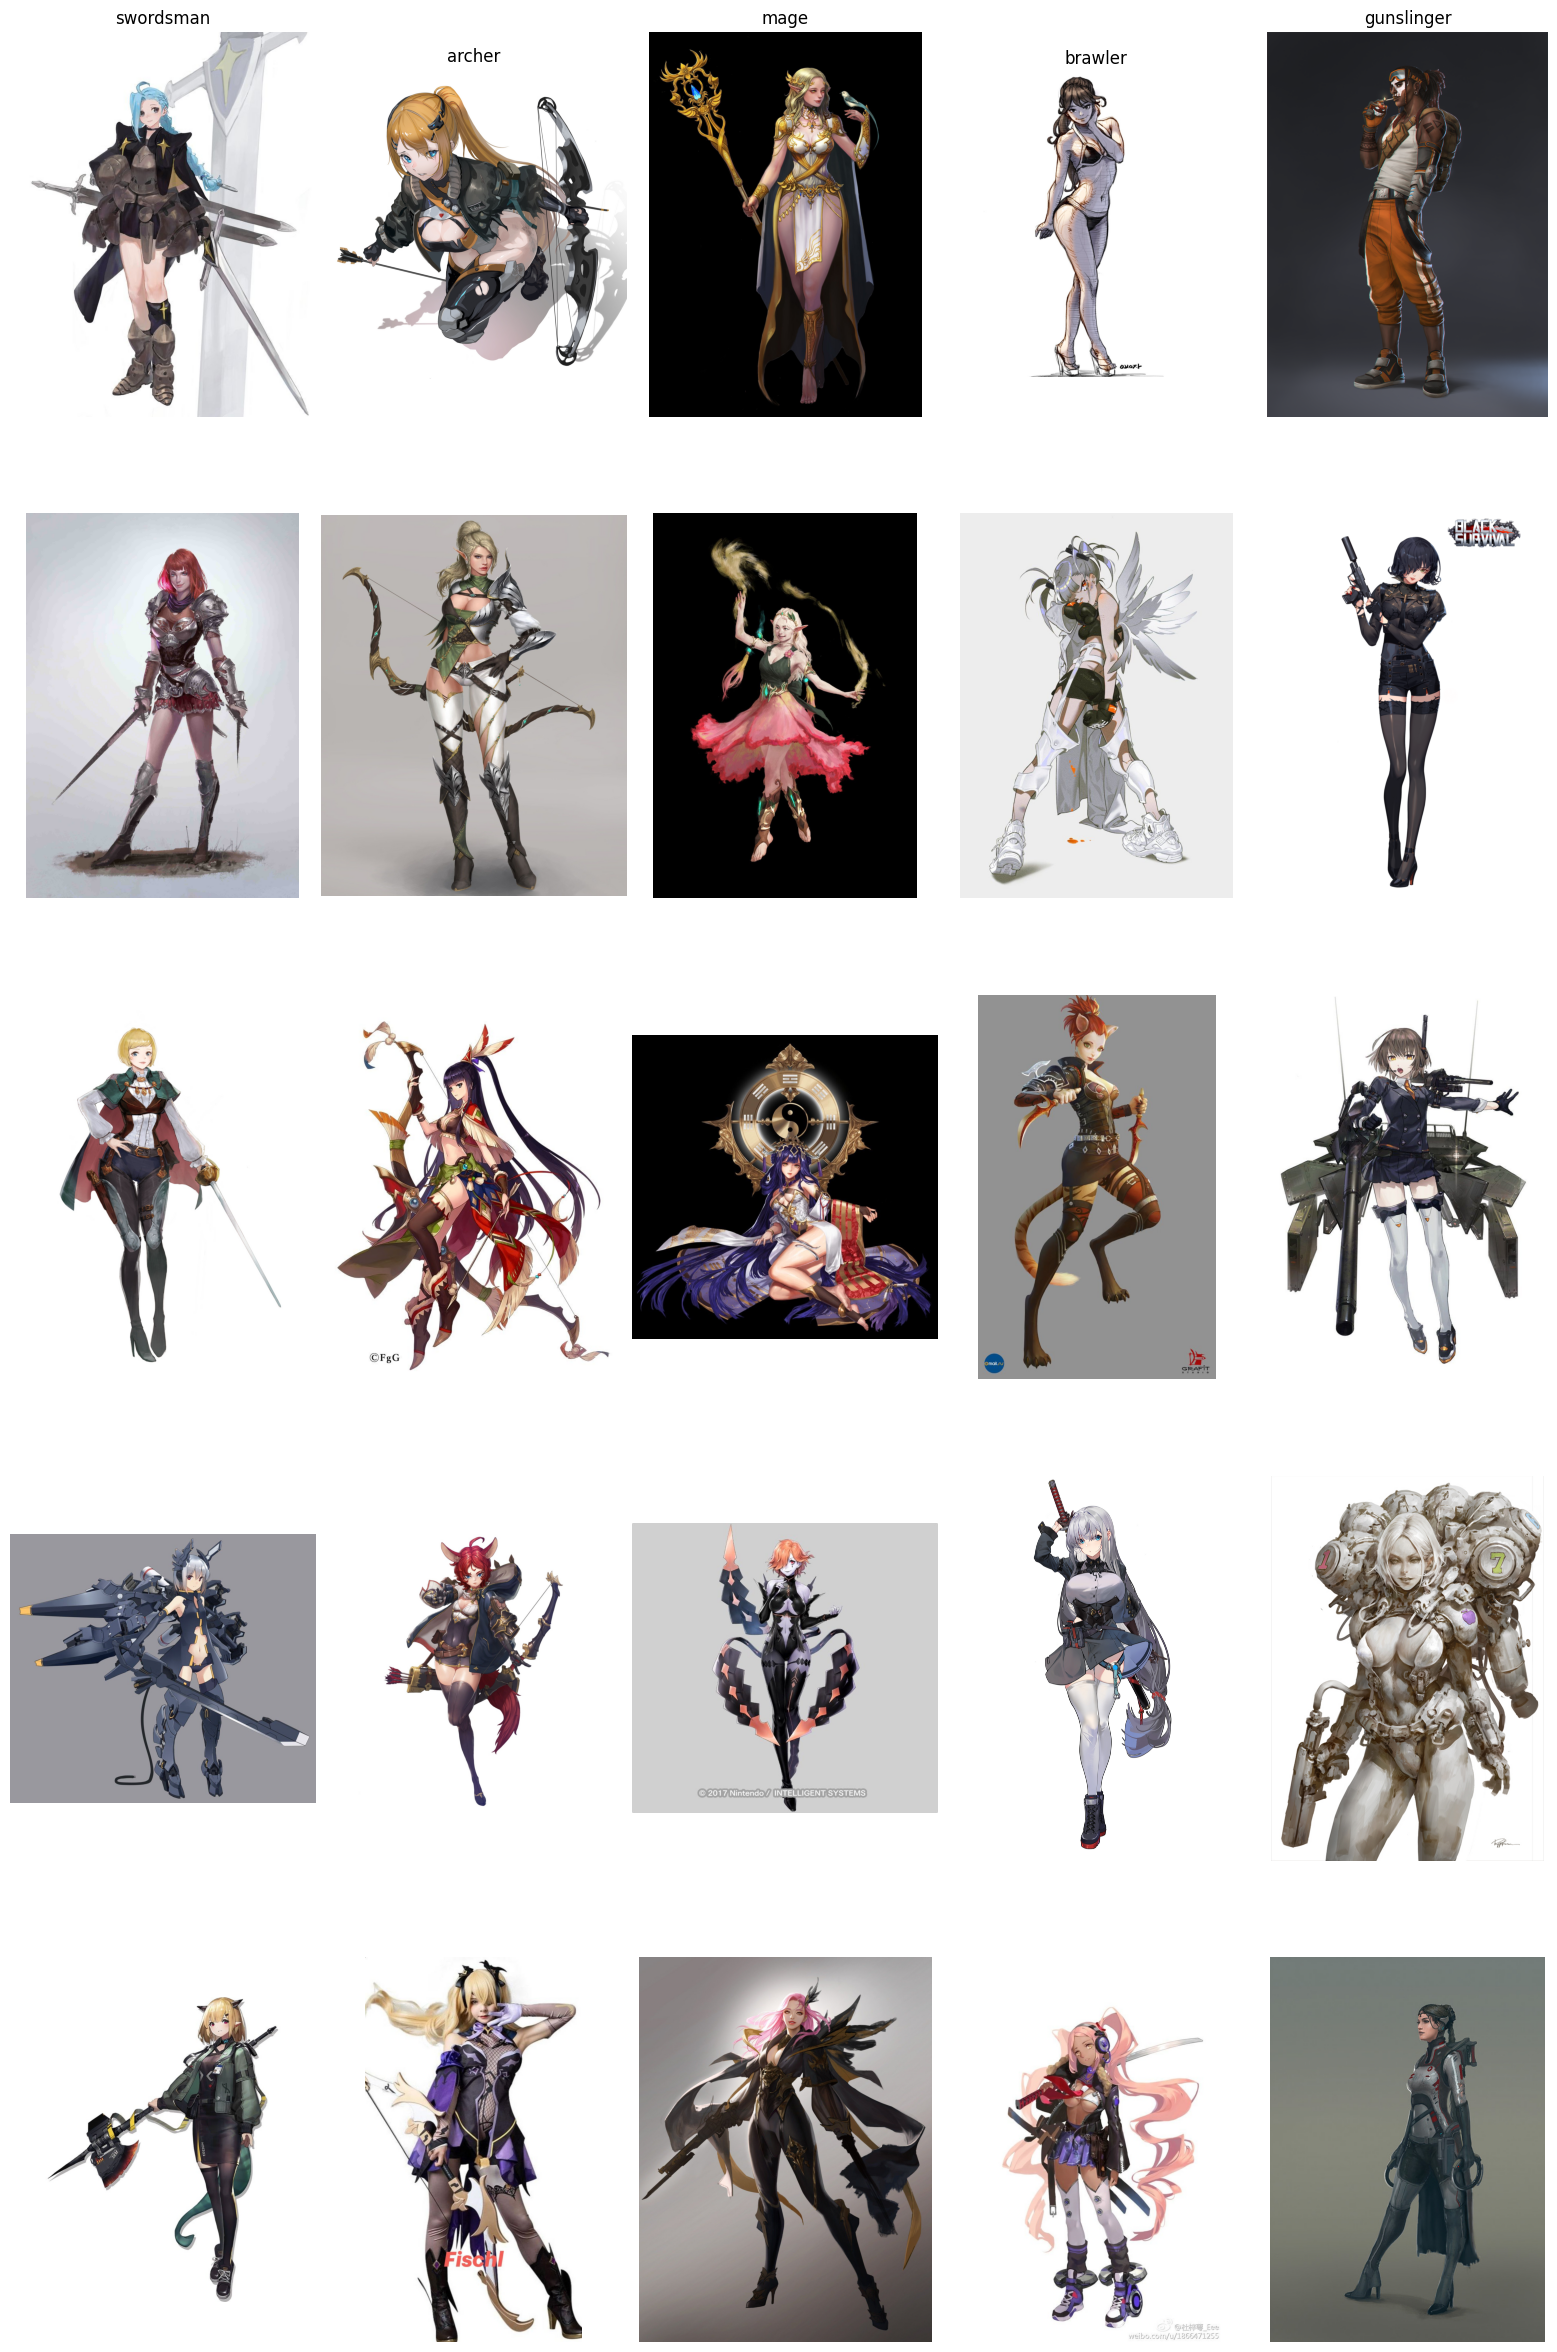

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
# Classes in column order
classes = [c[0] for c in class_names]

# Group paths by class
by_class = {c: [] for c in classes}
for path, c in imageClasses.items():
    if c in by_class:
        by_class[c].append(path)

# Shuffle within each class for random, no-replacement sampling
for c in classes:
    random.shuffle(by_class[c])

# Choose rows so the grid can be fully filled if possible (max 5)
rows = min(5, *(len(by_class[c]) for c in classes))  # ensures same number of rows per class
if rows == 0:
    raise SystemExit("No complete rows can be formed (one or more classes are empty).")

# Select the images: first `rows` from each shuffled list (no replacement)
selection = {c: by_class[c][:rows] for c in classes}

# Build the grid
fig, axes = plt.subplots(rows, len(classes), figsize=(4 * len(classes), 6*rows))
fig.subplots_adjust(hspace=0.25, wspace=0.02)

# Normalize axes handling for rows==1 case
if rows == 1:
    axes = [axes]

# Render
for col, cls in enumerate(classes):
    for row in range(rows):
        ax = axes[row][col] if rows > 1 else axes[col]
        path = selection[cls][row]
        try:
            img = mpimg.imread(path)
            ax.imshow(img)
        except Exception:
            # Fallback placeholder
            ax.text(0.5, 0.5, os.path.basename(path), ha="center", va="center", wrap=True, fontsize=7)
        ax.axis("off")
        if row == 0:
            ax.set_title(cls, fontsize=12)

plt.show()

In [21]:
import os
import io
import base64
from PIL import Image, ImageOps, UnidentifiedImageError
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Resolve candidate paths for the "true" folder
candidates = [Path("/mnt/data/true"), Path("./true")]
input_dir = None
for c in candidates:
    if c.exists() and c.is_dir():
        input_dir = c
        break

records = []
supported_exts = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tif", ".tiff", ".gif"}

if input_dir is None:
    df = pd.DataFrame(columns=[
        "file_path", "compressed_format", "width", "height",
        "original_size_bytes", "compressed_size_bytes", "compressed_base64"
    ])
    preview = df
    out_csv = None
else:
    for root, dirs, files in os.walk(input_dir):
        for fname in tqdm(files):
            ext = Path(fname).suffix.lower()
            if ext not in supported_exts:
                continue
            fpath = Path(root) / fname
            try:
                original_size = fpath.stat().st_size
            except OSError:
                original_size = None
            try:
                with Image.open(fpath) as im:
                    # Normalize orientation
                    im = ImageOps.exif_transpose(im)

                    # If animated, just use first frame
                    if getattr(im, "is_animated", False):
                        im = im.convert("RGBA")

                    # --- NEW: Resize if either dimension > 1000, keeping aspect ratio ---
                    if max(im.size) > 1000:
                        # thumbnail keeps aspect ratio and only downsizes
                        im.thumbnail((1000, 1000), Image.LANCZOS)
                    # --------------------------------------------------------------------

                    has_alpha = (im.mode in ("RGBA", "LA")) or ("transparency" in im.info)
                    if has_alpha:
                        out_format = "PNG"   # preserves transparency
                        save_params = {"optimize": True}
                        if im.mode not in ("RGBA", "LA"):
                            im = im.convert("RGBA")
                    else:
                        out_format = "JPEG"
                        save_params = {"quality": 60, "optimize": True, "progressive": True}
                        if im.mode not in ("RGB",):
                            im = im.convert("RGB")

                    buf = io.BytesIO()
                    im.save(buf, format=out_format, **save_params)
                    compressed_bytes = buf.getvalue()
                    compressed_b64 = base64.b64encode(compressed_bytes).decode("ascii")
                    width, height = im.size
                    compressed_size = len(compressed_bytes)

                    records.append({
                        "file_path": str(fpath),
                        "compressed_format": out_format,
                        "width": width,
                        "height": height,
                        "original_size_bytes": original_size,
                        "compressed_size_bytes": compressed_size,
                        "compressed_base64": compressed_b64
                    })
            except (UnidentifiedImageError, OSError):
                continue

    df = pd.DataFrame.from_records(records)
    out_csv = Path("compressed_images.csv")
    df.to_csv(out_csv, index=False)


100%|█████████████████████████████████████████████████████████████████████████████| 12303/12303 [17:19<00:00, 11.83it/s]


file_path compressed_format  width  \
0  true/Uploaded by user umespiao -9b06ea94ccc96f...              JPEG    894   
1  true/Uploaded by user umespiao -be3a42d95bbb1d...              JPEG    598   
2  true/wattpad.com The-Supreme-Beings-of-Life-an...              JPEG    720   
3  true/Uploaded by user umespiao -e5eb76927240e7...              JPEG    707   
4  true/Uploaded by user unknown -440446259f9e977...              JPEG    554   
5  true/Uploaded by user umespiao -378f76df8dbee3...              JPEG    964   
6  true/Uploaded by user umespiao -d1e8bec74800ae...              JPEG    672   
7  true/wattpad.com Aniquilando-Mundos-Mundo-Irin...              JPEG    679   
8  true/Uploaded by user umespiao -d95cef30f0251b...              JPEG   1000   
9  true/artstation.com Wild-Sea-Pirate-II-Eve-Ven...              JPEG    511   

   height  original_size_bytes  compressed_size_bytes  \
0    1000               259587                  56050   
1    1000               187280                  55128   
2     817                42314                  34722   
3    1000               170634                  48062   
4     896               126889                  81065   
5    1000                92967                  57172   
6     936                76946                  57774   
7    1000                94245                  48214   
8     930               193206                  46099   
9    1000                97997                  30752   

                                   compressed_base64  
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
5  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
6  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
7  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
8  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
9  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...

In [1]:
import base64
import io
import random
import numpy as np
from typing import Optional
from PIL import Image, ImageOps

def transform_image_to_array(
    b64_image: str,
    *,
    seed: Optional[int] = None,
    epsilon: float = 1e-3
) -> np.ndarray:
    """
    Decode a base64-encoded image, then:
      - If aspect ratio is exactly 3:2 (within epsilon), resize to 384x256.
      - Otherwise, crop the largest *random* 3:2 region possible, then resize to 384x256.
    Returns: NumPy array (H, W, C) in RGB or RGBA.

    Args:
        b64_image: Base64-encoded bytes of the source image (PNG/JPEG/etc.).
        seed: Optional RNG seed for reproducible random crops.
        epsilon: Tolerance when checking if aspect ratio equals 3:2.
    """
    if seed is not None:
        random.seed(seed)

    # 1) Decode
    img_bytes = base64.b64decode(b64_image)
    with Image.open(io.BytesIO(img_bytes)) as im:
        # Normalize orientation and ensure manipulable format
        im = ImageOps.exif_transpose(im)
        if im.mode not in ("RGB", "RGBA"):
            im = im.convert("RGB")

        W, H = im.size
        target_ratio = 2 / 3
        current_ratio = W / H

        # 2) If already ~3:2, just resize
        if abs(current_ratio - target_ratio) <= epsilon:
            out = im.resize((256, 384), Image.LANCZOS)
        else:
            # 3) Otherwise, crop largest random 3:2 portion
            if current_ratio > target_ratio:
                # Too wide: crop width
                crop_w = int(round(H * target_ratio))
                crop_h = H
                max_x = W - crop_w
                x0 = random.randint(0, max(0, max_x)) if max_x > 0 else 0
                y0 = 0
            else:
                # Too tall: crop height
                crop_w = W
                crop_h = int(round(W / target_ratio))
                max_y = H - crop_h
                x0 = 0
                y0 = random.randint(0, max(0, max_y)) if max_y > 0 else 0

            box = (x0, y0, x0 + crop_w, y0 + crop_h)
            cropped = im.crop(box)
            out = cropped.resize((256, 384), Image.LANCZOS)
        out = out.convert("RGBA")  # ensure alpha channel exists
        arr = np.array(out, dtype=np.uint8)
    
        # condition: fully transparent AND RGB = 0,0,0
        mask = (arr[..., 3] == 0) & (arr[..., :3] == 0).all(axis=-1)
    
        # set those to white in RGB, keep alpha unchanged
        arr[mask, :3] = [255, 255, 255]
    
        # return normalized RGB only
        return (arr.astype(np.float32) / 255.0)[..., :3]


In [2]:
import pandas as pd
parameters = {
    "sigma_min" : 0.002,
    "sigma_max" : 80,
    "sigma_data" : 0.5,
    "rho" : 7,
    "P_mean" : -1.2,
    "P_std" : 1.2,
    "N" : 128
}
df = pd.read_csv('compressed_images.csv')
df.head()

file_path compressed_format  width  \
0  true/Uploaded by user umespiao -9b06ea94ccc96f...              JPEG    894   
1  true/Uploaded by user umespiao -be3a42d95bbb1d...              JPEG    598   
2  true/wattpad.com The-Supreme-Beings-of-Life-an...              JPEG    720   
3  true/Uploaded by user umespiao -e5eb76927240e7...              JPEG    707   
4  true/Uploaded by user unknown -440446259f9e977...              JPEG    554   

   height  original_size_bytes  compressed_size_bytes  \
0    1000               259587                  56050   
1    1000               187280                  55128   
2     817                42314                  34722   
3    1000               170634                  48062   
4     896               126889                  81065   

                                   compressed_base64  
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...  
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA0JCgsKCA0LCg...

In [3]:
import json
with open("imageClass.json", "r") as f:
    imageClassDict = json.loads(f.read())
set(imageClassDict.values())
classToIdx = {
    'archer' : 0,
    'brawler' : 1,
    'gunslinger' : 2,
    'mage' : 3,
    'swordsman' : 4,
    'unconditioned' : 5
}

In [4]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import einx

def sampleNoiseVector(sigma, height=384, width=256, channels=3):
    return np.random.normal(
        loc=0.0, 
        scale=sigma, 
        size=(height, width, channels)
    )
def sampleNoisedImage(df, P_mean = -1.2, P_std = 1.2, height=384, width = 256, device='cpu'):
    idx = random.randint(0, df.shape[0] - 1)
    filePath = list(df['file_path'])[idx]
    className = imageClassDict[filePath]
    if random.random() > 0.5:
        classIdx = 5
    else:
        classIdx = classToIdx[className]
    imageTensor = torch.tensor(transform_image_to_array(list(df['compressed_base64'])[idx]))
    r = Resize((384 // 4, 256 // 4))
    imageTensor = einx.rearrange("c h w -> h w c", r(einx.rearrange("h w c -> c h w", imageTensor)))
    logSigma = np.random.normal(loc=P_mean, scale=P_std)
    sigma = np.e ** logSigma
    noiseVec = torch.tensor(sampleNoiseVector(sigma, height=height, width=width))
    
    return imageTensor.to(device), (imageTensor + noiseVec).to(device), torch.tensor([sigma]), torch.tensor([classIdx])

def sampleImageBatch(df, batch_size = 16, device='cpu', height=384, width = 256):
    trueImages = []
    noisedImages = []
    sigmaTensor = []
    classIndices = []
    for _ in range(batch_size):
        trueImage, noisedImage, sigma, classIdx = sampleNoisedImage(df, height=height, width = width)
        trueImages.append(trueImage)
        noisedImages.append(noisedImage)
        sigmaTensor.append(sigma)
        classIndices.append(classIdx)
    return torch.stack(trueImages).float().to(device), torch.stack(noisedImages).float().to(device), torch.stack(sigmaTensor).float().to(device), torch.stack(classIndices).long().to(device)
newHeight = 384 // 4
newWidth = 256 // 4
print(newHeight)
print(newWidth)


96
64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05978477746248245..1.0000001192092896].


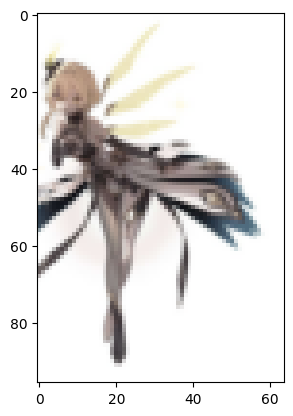

In [5]:
tmp = sampleNoisedImage(df, height=newHeight, width=newWidth, P_mean=-100)[1]
plt.imshow(tmp) 

In [6]:

def timeIndex(i, sigma_min, sigma_max, rho, N):
    sigmaDiff = sigma_min ** (1 / rho) - sigma_max ** (1 / rho)
    insideParenth = sigma_max ** (1 / rho) + (i / (N - 1)) * sigmaDiff
    return insideParenth ** rho 

def sigmaSchedule(t):
    return t

def computeTimeValues():
    timeIndices = []
    for idx in range(parameters["N"]):
        timeIndices.append(timeIndex(idx, parameters['sigma_min'], parameters['sigma_max'], parameters['rho'], parameters['N']))
    timeIndices.append(0)
    return timeIndices
timeValues = computeTimeValues()
print("t_0 through t_N")
print(f"{', '.join(str(x) for x in timeValues[:10])}...{', '.join(str(x) for x in timeValues[-10:])}")

t_0 through t_N
80.0, 76.62365808076356, 73.37019952280082, 70.23587449514882, 67.21702527325486, 64.3100845316542, 61.51157365787813, 58.818101087459674, 56.22636065990345, 53.73312999548703...0.008196339811421772, 0.006973725158819677, 0.005910883745528433, 0.004990022777169731, 0.004194971294060287, 0.0035110666704456605, 0.0029250465376888125, 0.0024249459985881193, 0.002000000000000003, 0


In [7]:
import einx
import torch.nn as nn
import torch

einx.rearrange("... (hIdx hPatch) (wIdx wPatch) c -> ... (hIdx wIdx) (hPatch wPatch c)", sampleNoisedImage(df, height=newHeight, width=newWidth)[1], hPatch = 8, wPatch = 8).shape

torch.Size([96, 192])

In [8]:
class Stem(nn.Module):
    def __init__(self, d_model, imageHeight=384, imageWidth=256, patchHeight=16, patchWidth=16, num_classes = 6):
        super().__init__()
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth
        self.patchHeight = patchHeight
        self.patchWidth = patchWidth
        self.lin = nn.Linear(patchHeight * patchWidth * 3, d_model)
        self.noiseLin = nn.Linear(1, d_model)
        self.classEmb = nn.Embedding(num_classes, d_model)
    def forward(self, imgTensor, noiseMagnitude, classTensor):
        imgReshaped = einx.rearrange("... (hIdx hPatch) (wIdx wPatch) c -> ... (hIdx wIdx) (hPatch wPatch c)",
                                     imgTensor,
                                     hPatch = self.patchHeight,
                                     wPatch = self.patchWidth)
        imgEmbeddings = self.lin(imgReshaped)
        classEmb = self.classEmb(classTensor)
        noiseEmb = self.noiseLin(noiseMagnitude)
        conditionEmbeddings = einx.rearrange("... (1 c), ... 1 c -> ... (1+1) c", noiseEmb, classEmb).sum(axis=-2)
        return imgEmbeddings, conditionEmbeddings
trueImages, noisedImages, sigmaTensor, classTensor = sampleImageBatch(df, height=newHeight, width=newWidth)
s = Stem(8, imageHeight = newHeight, imageWidth = newWidth, patchHeight = 8, patchWidth = 8)
print(s(noisedImages, sigmaTensor, classTensor)[0].shape)
print(s(noisedImages, sigmaTensor, classTensor)[1].shape)

torch.Size([16, 96, 8])
torch.Size([16, 8])


In [9]:
class DiTAdaLNBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, imageHeight=384, imageWidth=256, patchHeight=16, patchWidth=16):
        super().__init__()
        self.layerNorm1 = nn.LayerNorm(d_model, elementwise_affine=False)
        self.conditionedNormParamMLP = nn.Sequential(
            nn.Linear(d_model, d_model // 4),
            nn.SiLU(),
            nn.Linear(d_model // 4, d_model // 4),
            nn.SiLU(),
            nn.Linear(d_model // 4, d_model * 6, bias=False)
        )
        self.modelDim = d_model
        # initialize gammas to 1
        self.conditionedNormParamMLP[-1].weight.data[:d_model*2, :] = 1.0
        # initialize both betas and pre-residual alphas to 0 so that
        # no bias is added, and each residual block is the identity
        self.conditionedNormParamMLP[-1].weight.data[-d_model*4:, :] = 0.0
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)

        self.attentionLayer = nn.MultiheadAttention(d_model, n_heads, batch_first=True)

        self.layerNorm2 = nn.LayerNorm(d_model, elementwise_affine=False)

        self.ffwd = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.SiLU(),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, imageEmbeddings, conditioningEmbeddings):
        originalEmb = imageEmbeddings
        normParams = self.conditionedNormParamMLP(conditioningEmbeddings)
        gamma1, gamma2, beta1, beta2, alpha1, alpha2 = einx.rearrange("... (g1+b1+a1+g2+b2+a2) -> ... 1 g1, ... 1 b1, ... 1 a1, ... 1 g2, ... 1 b2, ... 1 a2",
                                                                      normParams,
                                                                      g1 = self.modelDim, b1 = self.modelDim, a1 = self.modelDim, g2 = self.modelDim, b2 = self.modelDim, a2 = self.modelDim
                                                                     )

        imageEmbeddings = self.layerNorm1(imageEmbeddings)
        imageEmbeddings = imageEmbeddings * gamma1 + beta1
        k, q, v = self.k(imageEmbeddings), self.q(imageEmbeddings), self.v(imageEmbeddings)
        imageEmbeddings, _ = self.attentionLayer(q, k, v)
        imageEmbeddings = imageEmbeddings * alpha1
        imageEmbeddings = imageEmbeddings + originalEmb

        originalEmb = imageEmbeddings
        imageEmbeddings = self.layerNorm2(imageEmbeddings)
        imageEmbeddings = imageEmbeddings * gamma2 + beta2
        imageEmbeddings = self.ffwd(imageEmbeddings) * alpha2
        
        return originalEmb + imageEmbeddings
trueImages, noisedImages, sigmaTensor, classTensor = sampleImageBatch(df, height=newHeight, width=newWidth)
imageEmbeddings, conditioningEmbeddings = s(noisedImages, sigmaTensor, classTensor)

ditblock = DiTAdaLNBlock(8, 16, 4, imageHeight=newHeight, imageWidth = newWidth, patchHeight=8, patchWidth=8)

ditblock(imageEmbeddings, conditioningEmbeddings).shape

torch.Size([16, 96, 8])

In [10]:
class DiTAdaLNFaithful(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, n_layers, imageHeight=384, imageWidth=256, patchHeight=16, patchWidth = 16):
        super().__init__()
        self.stem = Stem(d_model, imageHeight, imageWidth, patchHeight, patchWidth)
        self.positionEmb = nn.Embedding((imageHeight // patchHeight) * (imageWidth // patchWidth), d_model)
        
        self.diffusionTransformerLayers = nn.ModuleList([DiTAdaLNBlock(d_model, d_ff, n_heads, imageHeight, imageWidth, patchHeight, patchWidth) for _ in range(n_layers)])

        self.ln = nn.LayerNorm(d_model)
        self.finalLinear = nn.Linear(d_model, patchHeight * patchWidth * 3)
        self.patchHeight = patchHeight
        self.patchWidth = patchWidth
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth

    def forward(self, imgBatch, sigmaTensor, classTensor):
        imageEmbedding, conditionEmbedding = self.stem(imgBatch, sigmaTensor, classTensor)
        posEmb = self.positionEmb(torch.arange(imageEmbedding.shape[-2], device=imgBatch.device))
        if len(imageEmbedding.shape) == 3:
            posEmb = posEmb.unsqueeze(0)
        imageEmbedding = imageEmbedding + posEmb
        originalEmb = imageEmbedding
        for ditLayer in self.diffusionTransformerLayers:
            imageEmbedding = ditLayer(imageEmbedding, conditionEmbedding)
            
        imageEmbedding = self.ln(imageEmbedding)
        imagePixelspace = self.finalLinear(imageEmbedding)
        imagePixelspace = einx.rearrange("... (hIdx wIdx) (hPatch wPatch c) -> ... (hIdx hPatch) (wIdx wPatch) c",
                                         imagePixelspace,
                                         hIdx = self.imageHeight // self.patchHeight,
                                         wIdx = self.imageWidth // self.patchWidth,
                                         hPatch = self.patchHeight,
                                         wPatch = self.patchWidth,
                                         c = 3
                                        )
        return imagePixelspace


trueImages, noisedImages, sigmaTensor, classTensor = sampleImageBatch(df, height=newHeight, width=newWidth)

t = DiTAdaLNFaithful(16, 32, 16, 4, imageHeight = newHeight, imageWidth = newWidth, patchHeight = 8, patchWidth = 8)
t(noisedImages, sigmaTensor, classTensor).shape

torch.Size([16, 96, 64, 3])

In [11]:
trueImages, noisedImages, sigmaTensor, classTensor = sampleImageBatch(df, height=newHeight, width=newWidth)

t = DiTAdaLNFaithful(16, 32, 16, 4, imageHeight = newHeight, imageWidth = newWidth, patchHeight = 8, patchWidth = 8)
t(noisedImages, sigmaTensor, classTensor).shape

torch.Size([16, 96, 64, 3])

In [12]:
def calcLambda(sigmaTensor, sigma_data=0.5):
    numerator = sigmaTensor ** 2 + sigma_data ** 2
    denom = (sigmaTensor * sigma_data) ** 2
    return numerator / denom

def calcSkipScaling(sigmaTensor, sigma_data = 0.5):
    numerator = sigma_data ** 2
    denom = sigmaTensor ** 2 + sigma_data ** 2
    return numerator / denom

def calcOutputScaling(sigmaTensor, sigma_data=0.5):
    numerator = sigmaTensor * sigma_data
    denom = (sigmaTensor ** 2 + sigma_data ** 2) ** 0.5
    return numerator / denom

def calcInputScaling(sigmaTensor, sigma_data = 0.5):
    numerator = 1
    denom = (sigmaTensor ** 2 + sigma_data ** 2) ** 0.5
    return numerator / denom

def calcNoiseCond(sigmaTensor):
    return 0.25 * torch.log(sigmaTensor)
print(sigmaTensor[:10])
calcInputScaling(sigmaTensor)[:10]

tensor([[1.0423],
        [0.1076],
        [1.3833],
        [0.0744],
        [0.5692],
        [0.4582],
        [0.3655],
        [0.0469],
        [0.0868],
        [0.3787]])


tensor([[0.8650],
        [1.9553],
        [0.6799],
        [1.9782],
        [1.3200],
        [1.4745],
        [1.6145],
        [1.9913],
        [1.9705],
        [1.5944]])

In [13]:
def calculateLoss(denoisingModel, trueImages, noisedImages, sigmaTensor, classTensor):
    lamb = calcLambda(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_skip = calcSkipScaling(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_out = calcOutputScaling(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_in = calcInputScaling(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_noise = calcNoiseCond(sigmaTensor)
    
    # So that it can be broadcasted to be multiplied element wise against images in the batch
    c_in_expl = c_in.unsqueeze(-1).unsqueeze(-1)
    c_skip_expl = c_skip.unsqueeze(-1).unsqueeze(-1)
    c_out_expl = c_out.unsqueeze(-1).unsqueeze(-1)
    
    modelImageInput = c_in_expl * noisedImages
    modelOutput = denoisingModel(modelImageInput, c_noise, classTensor)
    
    effectiveTrainingTarget = (1 / c_out_expl) * (trueImages - c_skip_expl * noisedImages)
    # These three lines if you follow the suggested expressions in the paper simplifies to
    # MSE(modelOutput, effectiveTrainingTarget) * some_constant_dependent_on_image_dimensions
    # Since lambda and c_out**2 are inverses, and the rest is a mean over the sum of your pixel errors
    # rather than the sum of your 
    interm = (modelOutput - effectiveTrainingTarget) ** 2
    normedDiff = torch.sum(einx.rearrange("... h w c -> ... (h w c)", interm), dim=-1, keepdim=True)
    weightedLoss = lamb * (c_out ** 2) * normedDiff
    return torch.mean(weightedLoss)
t.to('cpu')
loss = calculateLoss(t, trueImages.to('cpu'), noisedImages.to('cpu'), sigmaTensor.to('cpu'), classTensor.to('cpu'))
print(loss)

tensor(34269.3203, grad_fn=<MeanBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3866158..2.3819826].


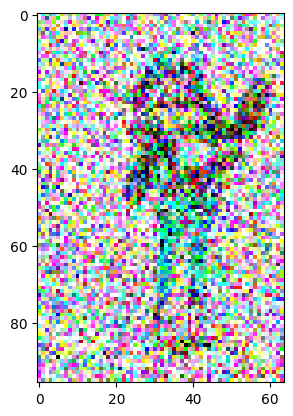

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78147554..1.692797].


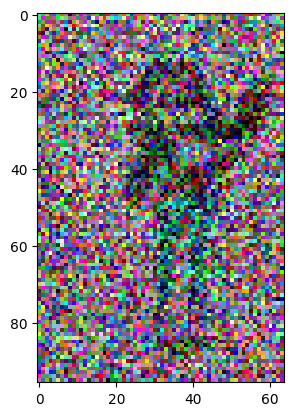

In [14]:
def calcTrueDenoised(denoisingModel, noisedImages, sigmaTensor, classTensor):
    c_skip = calcSkipScaling(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_out = calcOutputScaling(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_in = calcInputScaling(sigmaTensor, sigma_data = parameters['sigma_data'])
    c_noise = calcNoiseCond(sigmaTensor)
    
    # So that it can be broadcasted to be multiplied element wise against images in the batch
    c_in_expl = c_in.unsqueeze(-1).unsqueeze(-1)
    c_skip_expl = c_skip.unsqueeze(-1).unsqueeze(-1)
    c_out_expl = c_out.unsqueeze(-1).unsqueeze(-1)

    return c_skip_expl * noisedImages + c_out_expl * denoisingModel(c_in_expl * noisedImages, c_noise, classTensor)

def displayDenoisingProgress(model, noiseRange = (0.4, 0.6), device='cuda:0'):
    model.to(device)
    trueImages, noisedImages, sigmaTensor, classTensor = sampleImageBatch(df, device=device, height=newHeight, width=newWidth, batch_size=64)
    for idx in range(sigmaTensor.shape[0]):
        if sigmaTensor[idx][0] > noiseRange[0] and sigmaTensor[idx][0] < noiseRange[1]:
            plt.imshow(noisedImages[idx].cpu().numpy())
            plt.show()
            with torch.no_grad():
                denoised = calcTrueDenoised(model, noisedImages[idx], sigmaTensor[idx], classTensor[idx])
            plt.imshow(denoised.cpu().numpy())
            plt.show()
            break
displayDenoisingProgress(t)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 103.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6425211..2.87969].


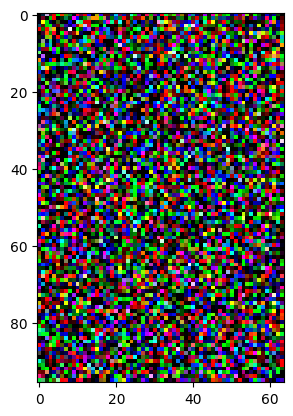

In [15]:
from tqdm import tqdm
timeValues = computeTimeValues()
def HeunSampleImage(denoisingModel, timeValues, device='cpu'):
    denoisingModel.to(device)
    generatedImages = []

    # Implicit assumption that sigma(t)=t and s(t) = 1 to make partial derivative calcs easy
    
    initImage = sampleNoiseVector(timeValues[0], height=newHeight, width=newWidth, channels=3)
    imgTensor = torch.tensor(initImage).float().to(device)
    classTensor = torch.tensor([5]).long().to(device)
    generatedImages.append(imgTensor.detach().cpu().numpy())
    for i in tqdm(range(len(timeValues) - 1)):
        timeVal = timeValues[i]
        sigmaTensor = torch.tensor([timeVal]).float().to(device)
        denoisedPred = calcTrueDenoised(denoisingModel, imgTensor, sigmaTensor, classTensor)
        dxdt = (imgTensor - denoisedPred) / timeVal
        imgTensorClone = imgTensor.clone()
        imgTensor = imgTensor + (timeValues[i + 1] - timeVal) * dxdt
        generatedImages.append(imgTensor.detach().cpu().numpy())

        if timeValues[i+1] != 0:
            sigmaTensor = torch.tensor([timeValues[i+1]]).float().to(device)
            dxdtprime = (imgTensor - calcTrueDenoised(denoisingModel, imgTensor, sigmaTensor, classTensor)) / timeValues[i+1]
            imgTensor = imgTensorClone + (timeValues[i+1] - timeValues[i]) * (0.5 * dxdt + 0.5 * dxdtprime)

    return imgTensor, generatedImages
with torch.no_grad():
    aaa, generatedImages = HeunSampleImage(t, timeValues, 'cuda:0')
plt.imshow(aaa.cpu().numpy())

In [20]:
for obj in dir():
    if isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

import torch.optim as optim
model = DiTAdaLNFaithful(768, 2048, 12, 12, imageHeight = newHeight, imageWidth = newWidth, patchHeight = 3, patchWidth = 2)

if loadFromState := False:
    ckpt = torch.load("ckpt-adaln.pt", map_location="cpu")  # or "cuda" if you want it on GPU
    
    model.load_state_dict(ckpt["model"])
    
    model.to('cuda:0')
    optimizer = optim.AdamW(model.parameters(), lr = 1e-4)
    
    # Restore model and optimizer states
    optimizer.load_state_dict(ckpt["optimizer"])
else:
    model.to('cuda:0')
    optimizer = optim.AdamW(model.parameters(), lr = 1e-4)

In [21]:
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

101020434


alloc:1574MiB
reserved:12514MiB
max_alloc:11791MiB

epoch: 0
loss: 34235.1719
min loss: 34235.1719
elapsed: 0.788 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 88.14it/s]


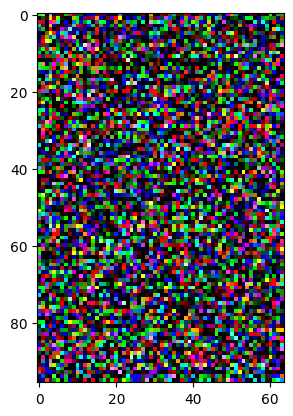

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 1000
loss: 4401.2871
min loss: 2330.7959
elapsed: 455.267 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.91it/s]


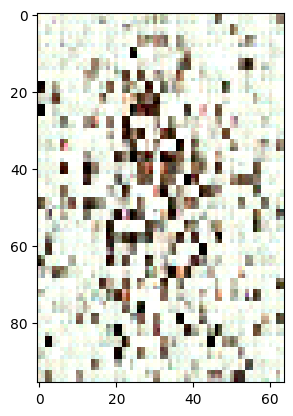

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 2000
loss: 2357.1423
min loss: 1759.0812
elapsed: 945.647 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.52it/s]


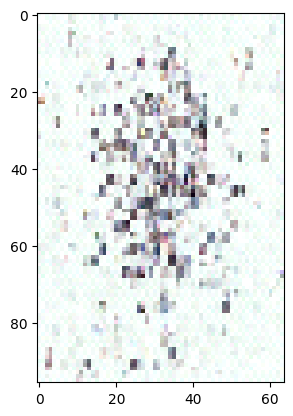

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 3000
loss: 3068.4055
min loss: 1408.1826
elapsed: 1478.015 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.44it/s]


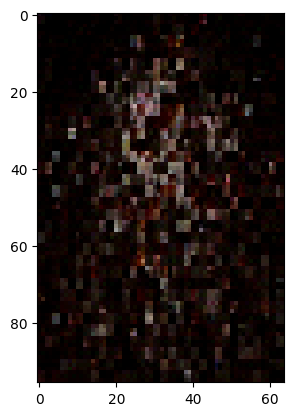

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 4000
loss: 2182.4814
min loss: 1240.4420
elapsed: 2036.638 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 30.38it/s]


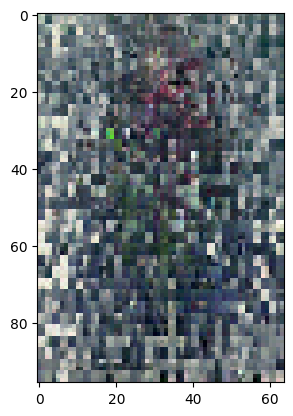

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 5000
loss: 2764.1042
min loss: 1095.7062
elapsed: 2629.700 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.88it/s]


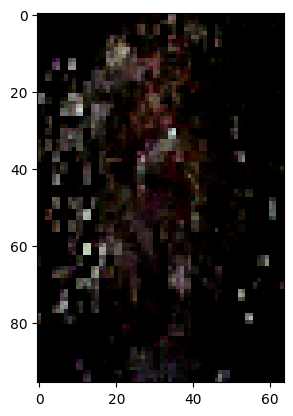

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 6000
loss: 1573.1672
min loss: 1069.6934
elapsed: 3258.761 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 30.07it/s]


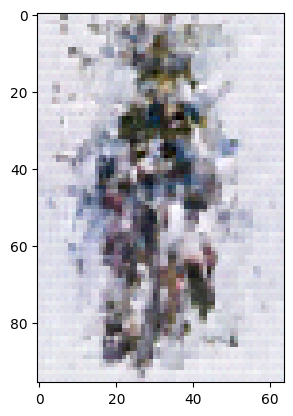

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 7000
loss: 1512.2592
min loss: 913.3861
elapsed: 3926.209 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.55it/s]


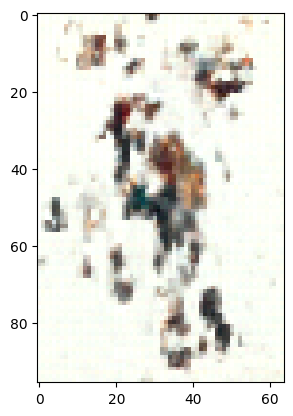

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 8000
loss: 1422.9852
min loss: 913.3861
elapsed: 4634.135 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 96.33it/s]


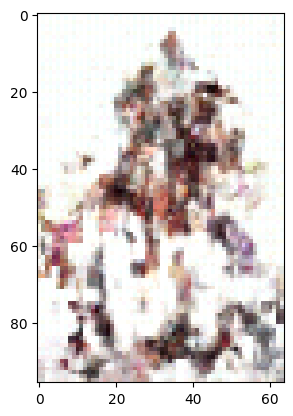

alloc:1572MiB
reserved:13284MiB
max_alloc:12569MiB

epoch: 9000
loss: 1207.4229
min loss: 769.7692
elapsed: 5371.844 secs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 30.01it/s]


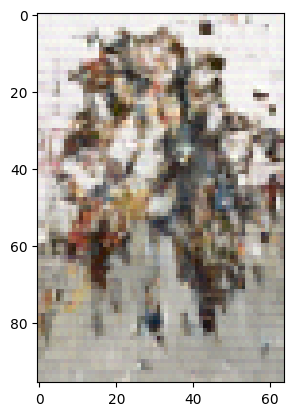

In [ ]:
# --- add these imports once ---
import mlflow
import mlflow.pytorch
import time

timeValues = computeTimeValues()
minLoss = 1e1000


# (optional) point to a server or local dir; otherwise MLflow uses ./mlruns
# mlflow.set_tracking_uri("http://localhost:5000")  # or "file:./mlruns"
mlflow.set_experiment("image-denoiser")  # change as you like

# (optional) capture common PyTorch metrics automatically (loss, LR, etc.)
# Set log_models=False if you don't want giant model artifacts every step.
mlflow.pytorch.autolog(log_models=False)
max_grad = 5000
minSaveInterval = 100
epochsSinceLastSave = 0
saveIfLossBelow = 2000
batch_size = 8
printEvery = 1000

imageGenProgress = []

run_name = f"train_{time.strftime('%Y%m%d_%H%M%S')}"
with mlflow.start_run(run_name=run_name):
    # ---- one-time params ----
    try:
        lr = optimizer.param_groups[0].get("lr")
    except Exception:
        lr = None
    try:
        import torch
        num_params = sum(p.numel() for p in model.parameters())
        model_name = model.__class__.__name__
        device_str = "cuda:0"
    except Exception:
        num_params = None
        model_name = None
        device_str = "cuda:0"

    mlflow.log_params({
        "batch_size": batch_size,
        "height": newHeight,
        "width": newWidth,
        "lr": lr,
        "clip_grad_norm": max_grad,
        "device": device_str,
        "model_class": model_name,
        "num_params": num_params
    })

    # ---- your existing training code, with a few MLflow hooks ----
    startTime = time.time()
    model.to(device_str)

    for epoch in range(100000):
        trueImages, noisedImages, sigmaTensor, classTensor = sampleImageBatch(
            df, batch_size=batch_size, device=device_str, height=newHeight, width=newWidth
        )
        optimizer.zero_grad()
        loss = calculateLoss(model, trueImages, noisedImages, sigmaTensor, classTensor)
        loss.backward()
        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad)
        optimizer.step()

        # --- log metrics every step ---
        mlflow.log_metric("grad_norm_before_clip", float(total_norm), step=epoch)
        mlflow.log_metric("loss", float(loss.item()), step=epoch)
        mlflow.log_metric("elapsed_sec", float(time.time() - startTime), step=epoch)
        epochsSinceLastSave += 1
        # save & log the best checkpoint as an artifact
        if loss.item() < minLoss:
            minLoss = loss.item()
            
        if loss.item() < saveIfLossBelow and epochsSinceLastSave > minSaveInterval:
            ckpt = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "loss": float(loss.item()),
            }
            try:
                torch.save(ckpt, "ckpt-adaln.pt")
            except KeyboardInterrupt:
                print("Delaying keyboard interrupt to save checkpoint")
                torch.save(ckpt, "ckpt-adaln.pt")
            mlflow.log_metric("best_loss", float(minLoss), step=epoch)

            epochsSinceLastSave = 0
            

        if epoch % printEvery == 0:
            cuda_mem_str = f"alloc:{torch.cuda.memory_allocated()//(1024**2)}MiB\nreserved:{torch.cuda.memory_reserved()//(1024**2)}MiB\nmax_alloc:{torch.cuda.max_memory_allocated()//(1024**2)}MiB\n"
            print(cuda_mem_str)
            print(f"""epoch: {epoch}
loss: {loss.item():.4f}
min loss: {minLoss:.4f}
elapsed: {time.time() - startTime:.3f} secs""")
            with torch.no_grad():
                aaa, generatedImages = HeunSampleImage(model, timeValues, 'cuda:0')
            plt.imshow(aaa.cpu().numpy())
            plt.show()
            imageGenProgress.append(aaa.cpu().numpy())


In [56]:
arr_clipped = np.clip(aaa.cpu().numpy(), 0, 1)

# Convert to 0–255 uint8 for saving as PNG
arr_uint8 = (arr_clipped * 255).astype(np.uint8)

# Save as PNG
img = Image.fromarray(arr_uint8)
img.save("coolGeneratedImages/8HoursTraining-1.png")


In [111]:
import numpy as np
import imageio.v3 as iio
from PIL import Image
from IPython.display import Video, display

def frames_to_mp4(frames, path="video.mp4", fps=24, scale=4):
    frames = np.asarray(frames)

    if frames.ndim == 3:
        frames = frames[..., None]  # grayscale → (N,H,W,1)

    # normalize/clip floats
    if np.issubdtype(frames.dtype, np.floating):
        frames = np.clip(frames, 0, 1)
        frames = (frames * 255).round().astype(np.uint8)
    elif frames.dtype != np.uint8:
        frames = frames.astype(np.uint8)

    upscaled = []
    for frame in frames:
        img = Image.fromarray(frame.squeeze() if frame.shape[-1]==1 else frame)
        new_size = (img.width * scale, img.height * scale)
        img = img.resize(new_size, resample=Image.NEAREST)  # NEAREST keeps sharp pixel edges
        upscaled.append(np.array(img))

    iio.imwrite(path, upscaled, fps=fps, codec="libx264", quality=8)
    return path

# Example usage (replace with your frames array):
# frames = np.random.rand(120, 120, 160, 3)  # 120 frames of 160x120 RGB float data
video_path = frames_to_mp4(generatedImages, "demo.mp4", fps=10, scale=5)
display(Video(video_path, embed=True))  # inline player with controls

In [76]:

from math import sqrt
from tqdm import tqdm

def EDMStochasticSampleImage(
    denoisingModel,
    timeValues,
    device='cpu',
    # Stochasticity controls (kept local to avoid changing your global `parameters`)
    S_churn=40.0,      # overall churn; tune per model/dataset if desired
    S_min=0.05,        # enable stochasticity only for σ in [S_min, S_max]
    S_max=50.0,
    S_noise=1.0        # inflate newly injected noise slightly (>1.0) if you see detail loss
):
    denoisingModel.to(device)
    denoisingModel.eval()

    # init from pure noise at t_0 (your schedule has t_N=0 appended)
    t0 = timeValues[0]
    img = torch.tensor(sampleNoiseVector(t0, height=newHeight, width=newWidth, channels=3)).float().to(device)
    cls = torch.tensor([5]).long().to(device)

    generatedImages = [img.detach().cpu().numpy()]

    N = len(timeValues) - 1  # number of transitions
    sqrt2m1 = sqrt(2.0) - 1.0

    for i in tqdm(range(N)):
        ti      = float(timeValues[i])
        tip1    = float(timeValues[i+1])

        # --- choose gamma_i (amount of churn) only within [S_min, S_max]
        gamma_i = (min(S_churn / max(N, 1), sqrt2m1) if (S_min <= ti <= S_max) else 0.0)

        # --- temporary increased noise level t_hat
        t_hat = ti * (1.0 + gamma_i)

        # --- add fresh noise to move from ti to t_hat
        if gamma_i > 0.0:
            # std of newly added noise
            add_std = (max(t_hat*t_hat - ti*ti, 0.0)) ** 0.5
            eps = torch.randn_like(img) * S_noise
            img_hat = img + add_std * eps
        else:
            img_hat = img

        # --- evaluate derivative d at (x_hat, t_hat):  d = (x - D(x;σ)) / σ
        sigma_tensor = torch.tensor([t_hat], dtype=torch.float32, device=device)
        D = calcTrueDenoised(denoisingModel, img_hat, sigma_tensor, cls)
        d = (img_hat - D) / t_hat

        # --- Euler step from t_hat to t_{i+1}
        img_euler = img_hat + (tip1 - t_hat) * d

        # --- optional Heun correction (2nd-order) when t_{i+1} != 0
        if tip1 != 0.0:
            sigma_next = torch.tensor([tip1], dtype=torch.float32, device=device)
            D_next = calcTrueDenoised(denoisingModel, img_euler, sigma_next, cls)
            d_prime = (img_euler - D_next) / tip1
            img = img_hat + (tip1 - t_hat) * (0.5 * d + 0.5 * d_prime)
        else:
            img = img_euler

        generatedImages.append(img.detach().cpu().numpy())

    return img, generatedImages

# Example usage (mirrors your Heun call)
with torch.no_grad():
    img_sto, frames_sto = EDMStochasticSampleImage(
        t, timeValues, device='cuda:0',
        S_churn=40.0, S_min=0.05, S_max=50.0, S_noise=1.0
    )

plt.imshow(img_sto.cpu().numpy())

  0%|                                                                                                                                                    | 0/128 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [0,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [0,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [0,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [0,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [0,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: blo

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
